While many parallel applications can be described as maps, some can be more complex.
In this section we look at the asynchronous Future interface,
which provides a simple API for ad-hoc parallelism.
This is useful for when your computations don't fit a regular pattern.

## Download data

In [1]:
%rm -rf data/  # remove the data directory to restart execution

In [2]:
import datetime
import os, sys
from glob import glob
import pandas as pd
import dask
import dask.dataframe as dd
try:
    import ujson as json
except ImportError:
    import json


here = os.getcwd() # get the current directory
# create data and minute directories
os.makedirs(os.path.join(here, 'data', 'minute'), exist_ok=True)

stocks = ['hal', 'hp', 'hpq', 'ibm', 'jbl', 'jpm', 'luv', 'pcg','usb']

def write_stock(symbol):
    """ Get demo files from google using dask library and write some
    csv files """
    dirname = os.path.join(here, 'data', 'minute', symbol)
    today = datetime.datetime.now().date()
    year = datetime.timedelta(days=365)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
        df = dd.demo.daily_stock(symbol, today - year, today, freq='30s',
                                 data_source='google')
        names = [str(ts.date()) for ts in df.divisions]
        df.to_csv(os.path.join(here, 'data', 'minute', symbol, '*.csv'),
                  name_function=names.__getitem__)
        print("Finished CSV: %s" % symbol)

for symbol in stocks:
    write_stock(symbol)


def convert_to_json(d):
    """ Convert all csv files of directory d into json format """
    filenames = sorted(glob(os.path.join(d, '*')))[-365:]
    outfn = d.replace('minute', 'json') + '.json'
    if os.path.exists(outfn):
        return
    with open(outfn, 'w') as f:
        for fn in filenames:
            df = pd.read_csv(fn)
            for rec in df.to_dict(orient='records'):
                json.dump(rec, f)
                f.write('\n')
    print("Finished JSON: %s" % d.split(os.path.sep)[-1])


js = os.path.join(here, 'data', 'json')
if not os.path.exists(js):
    os.mkdir(js)

directories = sorted(glob(os.path.join(here, 'data', 'minute', '*')))
for d in directories:
    convert_to_json(d)


Finished CSV: hal
Finished CSV: hp
Finished CSV: hpq
Finished CSV: ibm
Finished CSV: jbl
Finished CSV: jpm
Finished CSV: luv
Finished CSV: pcg
Finished CSV: usb
Finished JSON: hal
Finished JSON: hp
Finished JSON: hpq
Finished JSON: ibm
Finished JSON: jbl
Finished JSON: jpm
Finished JSON: luv
Finished JSON: pcg
Finished JSON: usb


In [17]:
import os, glob
filenames = sorted(glob.glob(os.path.join('data', 'json', '*.json')))
filenames

['data/json/hal.json',
 'data/json/hp.json',
 'data/json/hpq.json',
 'data/json/ibm.json',
 'data/json/jbl.json',
 'data/json/jpm.json',
 'data/json/luv.json',
 'data/json/pcg.json',
 'data/json/usb.json']

### Exercise 4.1
- Convert JSON data to HDF5 in parallel using `concurrent.futures`

In [18]:
%%time
import pandas as pd
import ujson as json # or json
for fn in filenames:
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')
    print("Finished : %s" % out_filename.split(os.path.sep)[-1])

Finished : hal.h5
Finished : hp.h5
Finished : hpq.h5
Finished : ibm.h5
Finished : jbl.h5
Finished : jpm.h5
Finished : luv.h5
Finished : pcg.h5
Finished : usb.h5
CPU times: user 6.17 s, sys: 730 ms, total: 6.9 s
Wall time: 6.98 s


## Application

Given our HDF5 files from the last section we want to find the two datasets with the greatest pair-wise correlation.  This forces us to consider all $n\times(n-1)$ possibilities.


In [19]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'json', '*.h5')))
filenames

['data/json/hal.h5',
 'data/json/hp.h5',
 'data/json/hpq.h5',
 'data/json/ibm.h5',
 'data/json/jbl.h5',
 'data/json/jpm.h5',
 'data/json/luv.h5',
 'data/json/pcg.h5',
 'data/json/usb.h5']

In [20]:

for fn in filenames:
    series[fn] = pd.read_hdf(fn)['close']

In [21]:
%%time

results = {}

for a in filenames:
    for b in filenames:
        if a != b:
            results[a, b] = series[a].corr(series[b])
            
((a, b), corr) = max(results.items(), key=lambda kv: kv[1])
print("%s matches with %s with correlation %f" % (a, b, corr))

data/json/jbl.h5 matches with data/json/pcg.h5 with correlation 0.946251
CPU times: user 310 ms, sys: 85.1 ms, total: 395 ms
Wall time: 394 ms


We use matplotlib to visually inspect the highly correlated timeseries

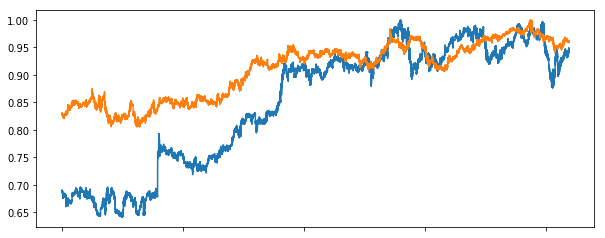

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a] / series[a].max())
plt.plot(series[b] / series[b].max())
plt.xticks(visible=False);